# Write data to and read data from a TFRecord file

Ilustrates how to read and write TFRecord files.

This is based on the examples [convert_to_records.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/convert_to_records.py) and [fully_connected_reader.py](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py) on the TensorFlow repository, and on [this post](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/).

More info can be found [here](https://www.tensorflow.org/tutorials/load_data/tf_records#tfrecord_files_using_tfpython_io).

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
import tensorflow as tf

In [2]:
tf.VERSION

'1.12.0'

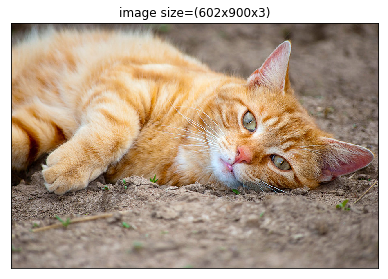

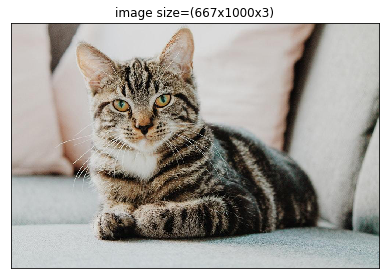

In [3]:
# We will define our own logic to load the images that will be stored on the tfrecordfile.
cat_array = io.imread('imgs/orange-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

cat_array = io.imread('imgs/gray-cat.jpg')
io.imshow(cat_array)
io.imshow(cat_array)
plt.title('image size=(%sx%sx%s)' % cat_array.shape)
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# The list of images and labels to be written to the TFRecords file
# The image is the same repeated. This is just an easy way of having
# two images with the same size.
filename_pairs = [('imgs/orange-cat.jpg', 'orange-cat'),
                  ('imgs/gray-cat.jpg', 'gray-cat')]

tfrecords_filename = 'cats.tfrecords'

In [5]:
# Define the types that will be written into the TFRecord file
def _bytes_feature(value):
    """Use this for string and byte types"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Use this for bool, enum, int32, uint32, int64 and uint64 types"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# This one is actually not used on this notebook. Its here just to see
# how the Float case would be
def _float_feature(value):
    """Use this for float (float32) and double (float64) types"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [6]:
# Check how a wrapped value looks like
print('_float_feature(4.5):', _float_feature(4.5))
print('_float_feature(4.5) (serialized):', _float_feature(4.5).SerializeToString())

_float_feature(4.5): float_list {
  value: 4.5
}

_float_feature(4.5) (serialized): b'\x12\x06\n\x04\x00\x00\x90@'


In [7]:
# Check how an `example` value looks like
features = {
    'a float feature': _float_feature(4.5),
    'a bytes feature': _bytes_feature(b'One cat is orange')
}
example = tf.train.Example(features=tf.train.Features(feature=features))
print(example)
print(example.SerializeToString())

features {
  feature {
    key: "a bytes feature"
    value {
      bytes_list {
        value: "One cat is orange"
      }
    }
  }
  feature {
    key: "a float feature"
    value {
      float_list {
        value: 4.5
      }
    }
  }
}

b'\nG\n(\n\x0fa bytes feature\x12\x15\n\x13\n\x11One cat is orange\n\x1b\n\x0fa float feature\x12\x08\x12\x06\n\x04\x00\x00\x90@'


In [8]:
# Write the images and labels to a TFRecord file:

# One can do this
# writer = tf.io.TFRecordWriter(tfrecords_filename)
# write and then 
# writer.close()
# but `with` is the usually-recommnded way.

# The steps to write on a TFRecord file are:
# 1. Create a TFRecord file
# 2. Load into variables the data that will be written.
# 3. Loop over the list of variables. The data will be written on the 
#    TFRecord file row by row.
# 4. Create a feature dictionary which has the column names (features)
#    as keys and the data converted on TensorFlow feature types.
# 5. Create an example with the feature dictionary,
#    which will be a row on the TFRecord file.
# 6. Serialize the examples if needed.
# 7. Write on the file.
# 8. Close the file.

with tf.io.TFRecordWriter(tfrecords_filename) as writer:
    for img_path, label in filename_pairs:
        img = io.imread(img_path)
        
        # Create an example, which will be a row on the TFRecord file
        # and on the dataset when reading it later.
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'height': _int64_feature(img.shape[0]),
                'width': _int64_feature(img.shape[1]),
                'image': _bytes_feature(img.tostring()),
                'label': _bytes_feature(label.encode(encoding='utf-8'))
            }))

        # Write the serialized example
        writer.write(example.SerializeToString())

In [9]:
# The following cells ilustrate how to read from
# TFRecord file to Dataset object and using it inside of a Session():
# 1. Load the TFRecord file to a dataset object with
#    the function tf.data.TFRecordDataset(tfrecords_filename).
# 2. Apply a map to the dataset with a function to parse the
#    data on the TFRecord file into python or TensorFlow types.
#    See the explanation
#    !!! This step is maybe simpler if done before setting a batch size,
#    otherwise inside of the parse function pased on the map, instead of
#    looping over serialized examples, the loop is done over, batches of
#    serialized example. So, it will be needed an internal loop over a
#    single serialized example to do the parsing.
# 3. Do the normal operations to a dataset to define the input pipeline:
#    other maps, repeat, make_one_shot_iterator, get_next, make_initializer, etc.
# 4. Use the dataset on a Session.

In [10]:
# Parse the TFRecord file with a map.

# The next function will be applied to the dataset through a map.
# Such function should take as argument a serialized example
# which is Tensor but it can be seen as a tuple.
# For instance, an empty
# function to be mapped can be:
# def decode(serialized_example):
#     return serialized_example
# 
# Because of this the function returns a tuple. This tuple doesn't
# need to be of the same size of the initial that comes when loading
# the TFRecord file. One can decode and convert the iteration over
# a dataset with more or less featureas, or with a different order of
# the features than the original on the TFRecord file. For instance
# the Session example 2, is done with the commented return on`decode`
# (return image, label) which creates a simple dataset with ony two features.
#
# The steps are the following:
# 1. Define a parser with the features that will be loaded and their
#    respective types. Pass the serialized example to the parser.
# 2. Cast each feature to the desired.
# 3. Return a tuple with the decoded data.
#
# The difference of this withe respect to the example outside the Session()
# where we used tf.train.Example intead of tf.parse_single_example
# is in the way the TFRecord is loaded. One he example above, the iteration
# goes over string records which are serialized data read as bytes from the 
# TFRecord file, while here since the TFRecord file was loaded into a Dataset
# object, the iteration goes over serialized examples which actually are
# containing serialized data. tf.train.Example expect string records, while
# tf.parse_single_example expect Tensors.
def decode(serialized_example):
    """Parses an image and label from the given `serialized_example`."""
    example = tf.parse_single_example(
        serialized_example,  # serialized_example is a Tensor
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.string),
        })
    width = tf.cast(example['width'], tf.int64)
    height = tf.cast(example['height'], tf.int64)
    image = tf.decode_raw(example['image'], tf.uint8)
    label = tf.cast(example['label'], tf.string)
    image = tf.reshape(image, (height, width, 3))  # optional
    return image, label

In [11]:
# Define the input pipeline
dataset = tf.data.TFRecordDataset(tfrecords_filename)
dataset = dataset.map(decode)
dataset = dataset.batch(1)
iterator = dataset.make_one_shot_iterator()
next_item = iterator.get_next()

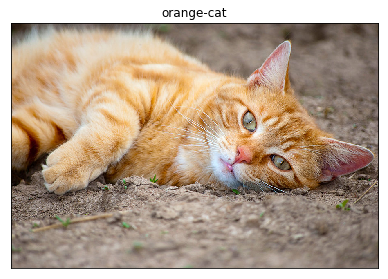

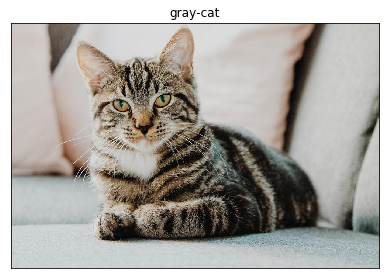

Done!


In [12]:
with tf.Session() as sess:
    try:
        while True:
            image, label = sess.run(next_item)
            io.imshow(image[0])
            plt.title(label[0].decode('utf-8'))
            plt.xticks([])
            plt.yticks([])
            plt.show()
    except tf.errors.OutOfRangeError:
        print('Done!')